# 新聞貼文病毒式傳播分析 (News Viral Pattern Analysis)

本筆記本將分析Milvus中的新聞貼文集合，找出病毒式傳播的模式。我們將：
1. 比較各群集的 count 和 created_time 分布
2. 識別一開始就特別活躍的群集（可能更容易爆紅）
3. 使用 centroid_vector 找出與已知爆紅新聞相似的群集主題

In [1]:
# 導入所需的庫
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from pymilvus import connections, Collection
from sklearn.metrics.pairwise import cosine_similarity

# 設定中文字體支持（如果需要）
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

# 設定繪圖風格
sns.set(style="whitegrid")

# 設定圖形大小
plt.figure(figsize=(12, 8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [9]:
!pip install wget
import wget

wget.download("https://github.com/GrandmaCan/ML/raw/main/Resgression/ChineseFont.ttf")
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.font_manager import fontManager

fontManager.addfont("ChineseFont.ttf")
mpl.rc('font', family="ChineseFont")

In [17]:
# 連接到 Milvus 服務器
try:
    connections.connect(
        alias="default", 
        host="localhost",  # 根據實際情況修改
        port="19530"       # 根據實際情況修改
    )
    print("成功連接到 Milvus 服務器")
except Exception as e:
    print(f"連接 Milvus 服務器時出錯: {e}")

成功連接到 Milvus 服務器


In [18]:
# 載入 Milvus 集合
try:
    # 載入新聞貼文集合
    news_posts = Collection("news_posts")
    news_posts.load()
    
    # 載入群集中心集合
    cluster_centroids = Collection("cluster_centroids")
    cluster_centroids.load()
    
    print("成功載入 Milvus 集合")
except Exception as e:
    print(f"載入 Milvus 集合時出錯: {e}")

成功載入 Milvus 集合


In [ ]:
import time
import pandas as pd

# 定義起始日期和結束日期
start_date = "2021-01-01"
end_date = "2021-04-14"

# 把日期字串轉為 timestamp
start_ts = 1609430400000000000
end_ts = 1618374574000000000

# 依天迭代
one_day = 86400 * 1_000_000_000  # 一天的奈秒數
curr_ts = start_ts
all_days_posts = []
all_days_cluster = pd.DataFrame()

while curr_ts < end_ts:
    next_ts = curr_ts + one_day
    posts_query = news_posts.query(
        expr=f"created_time >= {curr_ts} and created_time < {next_ts}",
        output_fields=["id", "batch_cluster", "created_time", "is_early_report", "is_viral_event"],
        limit=1000
    )

    # 從posts_query中獲取所有unique的batch_cluster
    batch_clusters = []
    for post in posts_query:
        if 'batch_cluster' in post and post['batch_cluster'] not in batch_clusters:
            batch_clusters.append(post['batch_cluster'])
    
    # 如果有找到batch_clusters，查詢對應的cluster_centroids
    if batch_clusters:
        # 構建查詢表達式來匹配所有相關的cluster_id
        expr = " or ".join([f"cluster_id == {cluster_id}" for cluster_id in batch_clusters])
        cluster_query = cluster_centroids.query(
            expr=expr,
            output_fields=["cluster_id", "centroid_vector", "count"],
            limit=len(batch_clusters)  # 只獲取對應的數量
        )
    else:
        # 如果沒有找到batch_clusters，返回空列表
        cluster_query = []

    # 轉換為 DataFrame
    cluster_df = pd.DataFrame(cluster_query)
    
    # 將當天的cluster數據添加到all_days_cluster
    if not cluster_df.empty:
        all_days_cluster = pd.concat([all_days_cluster, cluster_df], ignore_index=True)
    
    posts_df = pd.DataFrame(posts_query)
    posts_df['date'] = pd.to_datetime(posts_df['created_time'] // 1_000_000_000, unit='s').dt.date
    all_days_posts.append(posts_df)
    print(f"共獲取 {len(posts_df)} 個貼文數據，日期範圍：{posts_df['date'].min()} ~ {posts_df['date'].max()}")
    print(posts_df['date'].head())
    curr_ts = next_ts  # <--- 這一行確保每次查詢不同天

# 合併所有天的資料
final_df = pd.concat(all_days_posts, ignore_index=True)
print(f"總共抓取 {len(final_df)} 筆資料，日期範圍：{final_df['date'].min()} ~ {final_df['date'].max()}")

共獲取 1000 個貼文數據，日期範圍：2020-12-31 ~ 2021-01-01
0    2020-12-31
1    2020-12-31
2    2021-01-01
3    2021-01-01
4    2021-01-01
Name: date, dtype: object
共獲取 1000 個貼文數據，日期範圍：2021-01-01 ~ 2021-01-02
0    2021-01-02
1    2021-01-02
2    2021-01-02
3    2021-01-02
4    2021-01-02
Name: date, dtype: object
共獲取 1000 個貼文數據，日期範圍：2021-01-02 ~ 2021-01-03
0    2021-01-03
1    2021-01-03
2    2021-01-03
3    2021-01-03
4    2021-01-03
Name: date, dtype: object
共獲取 1000 個貼文數據，日期範圍：2021-01-03 ~ 2021-01-04
0    2021-01-04
1    2021-01-04
2    2021-01-04
3    2021-01-04
4    2021-01-04
Name: date, dtype: object
共獲取 1000 個貼文數據，日期範圍：2021-01-04 ~ 2021-01-05
0    2021-01-04
1    2021-01-05
2    2021-01-05
3    2021-01-04
4    2021-01-04
Name: date, dtype: object
共獲取 1000 個貼文數據，日期範圍：2021-01-05 ~ 2021-01-06
0    2021-01-05
1    2021-01-05
2    2021-01-05
3    2021-01-05
4    2021-01-05
Name: date, dtype: object
共獲取 1000 個貼文數據，日期範圍：2021-01-06 ~ 2021-01-07
0    2021-01-07
1    2021-01-07
2    2021-01-07
3    202

總共有 105 個不同日期
時間範圍: 2020-12-31 到 2021-04-14
2020-12-31: 抽取了 619 則記錄 (共 619 則)
2021-01-01: 抽取了 384 則記錄 (共 384 則)
2021-01-02: 抽取了 1000 則記錄 (共 1098 則)
2021-01-03: 抽取了 928 則記錄 (共 928 則)
2021-01-04: 抽取了 1000 則記錄 (共 1014 則)
2021-01-05: 抽取了 1000 則記錄 (共 1053 則)
2021-01-06: 抽取了 921 則記錄 (共 921 則)
2021-01-07: 抽取了 1000 則記錄 (共 1030 則)
2021-01-08: 抽取了 1000 則記錄 (共 1103 則)
2021-01-09: 抽取了 897 則記錄 (共 897 則)
2021-01-10: 抽取了 1000 則記錄 (共 1021 則)
2021-01-11: 抽取了 1000 則記錄 (共 1008 則)
2021-01-12: 抽取了 993 則記錄 (共 993 則)
2021-01-13: 抽取了 939 則記錄 (共 939 則)
2021-01-14: 抽取了 1000 則記錄 (共 1018 則)
2021-01-15: 抽取了 1000 則記錄 (共 1027 則)
2021-01-16: 抽取了 998 則記錄 (共 998 則)
2021-01-17: 抽取了 1000 則記錄 (共 1143 則)
2021-01-18: 抽取了 854 則記錄 (共 854 則)
2021-01-19: 抽取了 1000 則記錄 (共 1409 則)
2021-01-20: 抽取了 1000 則記錄 (共 1068 則)
2021-01-21: 抽取了 536 則記錄 (共 536 則)
2021-01-22: 抽取了 998 則記錄 (共 998 則)
2021-01-23: 抽取了 1000 則記錄 (共 1012 則)
2021-01-24: 抽取了 970 則記錄 (共 970 則)
2021-01-25: 抽取了 969 則記錄 (共 969 則)
2021-01-26: 抽取了 1000 則記錄 (共 1082 則)
2021-01-27

,batch_cluster,cluster_id,count
0,0,NaN,0
1,1,NaN,0
2,831,NaN,0
3,771,NaN,0
4,278,NaN,0
5,680,NaN,0
6,619,NaN,0
7,602,NaN,0
8,234,NaN,0
9,213,NaN,0



匹配成功率: 13.54% (11971/88432)

每日樣本與對應的cluster_id:


,created_time,is_early_report,is_viral_event,id,batch_cluster,date,cluster_id
0,1609430400000000000,True,False,19,0,2020-12-31,NaN
1,1609430400000000000,True,False,57,1,2020-12-31,NaN
2,1609449106000000000,True,False,128,831,2020-12-31,NaN
3,1609446450000000000,True,False,129,771,2020-12-31,NaN
4,1609432230000000000,True,False,130,278,2020-12-31,NaN



每天不同群集的數量分布:


,date,cluster_id,count
0,2020-12-31,14.0,2
1,2020-12-31,53.0,1
2,2020-12-31,96.0,4
3,2020-12-31,101.0,3
4,2020-12-31,119.0,3
5,2020-12-31,121.0,1
6,2020-12-31,122.0,1
7,2020-12-31,130.0,4
8,2020-12-31,131.0,3
9,2020-12-31,140.0,2


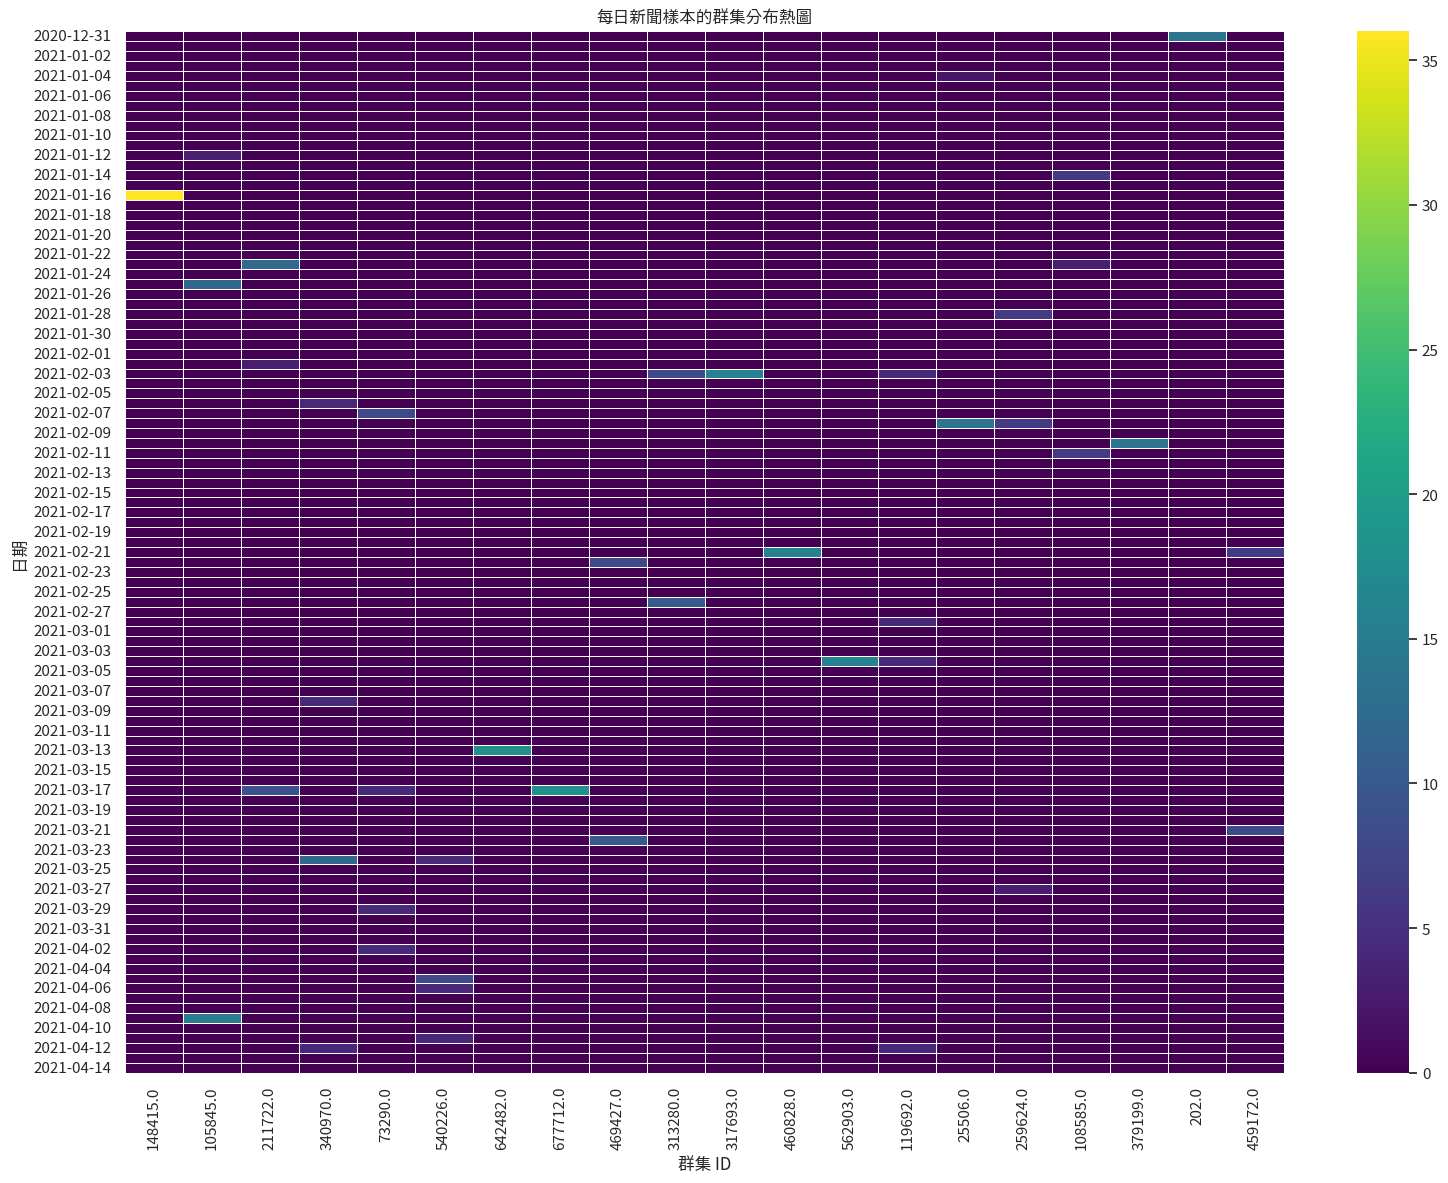


群集活躍時間統計（按貼文數量排序）:


,cluster_id,first_date,last_date,post_count,active_days
1884,148415.0,2021-01-16,2021-01-16,36,1
1356,105845.0,2021-01-12,2021-04-09,30,88
4219,340970.0,2021-02-06,2021-04-12,24,66
2557,211722.0,2021-01-23,2021-03-17,24,54
6788,540226.0,2021-03-24,2021-04-11,20,19
906,73290.0,2021-02-07,2021-04-02,20,55
3883,313280.0,2021-02-03,2021-02-26,18,24
8570,677712.0,2021-03-17,2021-03-17,18,1
5859,469427.0,2021-02-22,2021-03-22,18,29
8090,642482.0,2021-03-13,2021-03-13,18,1



結果已保存至: daily_sampled_news_with_clusters.csv

每日樣本分析完成！


In [21]:
# 根據 created_time 每天提取 1000 筆記錄並尋找對應的 cluster_id
try:
    
    # 獲取所有不同日期
    unique_dates = sorted(final_df['date'].unique())
    print(f"總共有 {len(unique_dates)} 個不同日期")
    print(f"時間範圍: {min(unique_dates)} 到 {max(unique_dates)}")
    
    # 建立一個空的DataFrame來存儲每天的1000則記錄
    daily_samples = []
    
    for date in unique_dates:
        # 篩選當天的記錄
        day_posts = final_df[final_df['date'] == date]
        
        # 如果當天記錄數超過1000，隨機抽取1000條
        if len(day_posts) > 1000:
            sampled_posts = day_posts.sample(n=1000, random_state=42)
        else:
            sampled_posts = day_posts  # 如果少於1000條，全部取用
        
        daily_samples.append(sampled_posts)
        print(f"{date}: 抽取了 {len(sampled_posts)} 則記錄 (共 {len(day_posts)} 則)")
    
    # 合併所有每日樣本
    daily_sampled_df = pd.concat(daily_samples, ignore_index=True)
    print(f"\n總共抽取了 {len(daily_sampled_df)} 則記錄")
    
    # 獲取這些樣本所屬的批次群集ID
    unique_batch_clusters = daily_sampled_df['batch_cluster'].unique()
    print(f"這些記錄屬於 {len(unique_batch_clusters)} 個不同的批次群集")
    
    # 在cluster_centroids中找出對應的cluster_id
    matched_clusters = []
    for batch_id in unique_batch_clusters:
        # 在cluster_centroids中查詢
        cluster_matches = all_days_cluster[all_days_cluster['cluster_id'] == batch_id]
        
        if not cluster_matches.empty:
            for _, cluster_row in cluster_matches.iterrows():
                matched_clusters.append({
                    'batch_cluster': batch_id,
                    'cluster_id': cluster_row['cluster_id'],
                    'count': cluster_row['count']
                })
        else:
            # 找不到對應cluster_id的情況
            matched_clusters.append({
                'batch_cluster': batch_id,
                'cluster_id': None,
                'count': 0
            })
    
    # 轉換為DataFrame
    matched_clusters_df = pd.DataFrame(matched_clusters)
    
    # 顯示匹配結果
    print("\n批次群集與集中群集的匹配結果：")
    display(matched_clusters_df.head(20))
    
    # 計算匹配成功率
    match_success = matched_clusters_df['cluster_id'].notna().sum()
    match_rate = match_success / len(matched_clusters_df) * 100
    print(f"\n匹配成功率: {match_rate:.2f}% ({match_success}/{len(matched_clusters_df)})")
    
    # 將匹配結果合併到原始的每日樣本中
    result_df = pd.merge(
        daily_sampled_df,
        matched_clusters_df[['batch_cluster', 'cluster_id']],
        on='batch_cluster',
        how='left'
    )
    
    # 顯示最終結果
    print("\n每日樣本與對應的cluster_id:")
    display(result_df.head())
    
    # 根據日期分組並計算群集分布
    cluster_date_counts = result_df.groupby(['date', 'cluster_id']).size().reset_index(name='count')
    print("\n每天不同群集的數量分布:")
    display(cluster_date_counts.head(20))
    
    # 繪製熱圖顯示每日的群集分布情況
    try:
        # 取前20個最常見的群集
        top_clusters = result_df['cluster_id'].value_counts().nlargest(20).index.tolist()
        
        # 創建透視表
        date_cluster_pivot = pd.pivot_table(
            cluster_date_counts, 
            values='count', 
            index='date', 
            columns='cluster_id',
            fill_value=0
        )
        
        # 取得可用的群集
        available_clusters = [c for c in top_clusters if c in date_cluster_pivot.columns]
        
        if available_clusters:
            plt.figure(figsize=(16, 12))
            sns.heatmap(
                date_cluster_pivot[available_clusters],
                cmap='viridis',
                annot=False,
                fmt='g',
                linewidths=.5
            )
            plt.title('每日新聞樣本的群集分布熱圖')
            plt.xlabel('群集 ID')
            plt.ylabel('日期')
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"繪製熱圖時出錯: {e}")
    
    # 分析各群集的時間跨度
    # 先將日期轉換為datetime格式
    result_df['date'] = pd.to_datetime(result_df['date'])
    
    cluster_activity = result_df.groupby('cluster_id').agg(
        first_date=('date', 'min'),
        last_date=('date', 'max'),
        post_count=('id', 'count')
    ).reset_index()
    
    # 計算活躍天數
    cluster_activity['active_days'] = (cluster_activity['last_date'] - cluster_activity['first_date']).dt.days + 1
    
    # 根據貼文數量排序
    cluster_activity = cluster_activity.sort_values(by='post_count', ascending=False)
    
    print("\n群集活躍時間統計（按貼文數量排序）:")
    display(cluster_activity.head(20))
    
    # 保存結果
    result_path = 'daily_sampled_news_with_clusters.csv'
    result_df.to_csv(result_path, index=False)
    print(f"\n結果已保存至: {result_path}")
    
    print("\n每日樣本分析完成！")
    
except Exception as e:
    print(f"處理每日樣本時出錯: {e}")
    import traceback
    traceback.print_exc()

In [ ]:
# 釋放 Milvus 資源
try:
    news_posts.release()
    cluster_centroids.release()
    print("成功釋放 Milvus 集合資源")
    
    # 斷開與 Milvus 的連接
    connections.disconnect("default")
    print("成功斷開 Milvus 連接")
except Exception as e:
    print(f"釋放資源時出錯: {e}")